In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-bp_s43nl
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-bp_s43nl
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369409 sha256=f647ae8186086b06ef79731f8deacf9b0f66c8b902eda771d6c94b904ca20a5a
  Stored in directory: /tmp/pip-ephem-wheel-cache-cux1zncm/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [ ]:
!git clone https://github.com/ndb796/StyleCLIP-Tutorial
%cd /content/StyleCLIP-Tutorial

Cloning into 'StyleCLIP-Tutorial'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 64 (delta 19), reused 10 (delta 0), pack-reused 0
Unpacking objects: 100% (64/64), done.
/content/StyleCLIP-Tutorial


In [ ]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EVv6yusEt1tFhrL3TCu0Ta4BlpzW3eBMTS0yTPKodNHsNA?download=1 -O stylegan2-ffhq-config-f.pt

--2022-11-02 14:38:20--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EVv6yusEt1tFhrL3TCu0Ta4BlpzW3eBMTS0yTPKodNHsNA?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/stylegan2-ffhq-config-f.pt?ga=1 [following]
--2022-11-02 14:38:22--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/stylegan2-ffhq-config-f.pt?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 381462551 (364M) [application/octet-stream]
Saving to: ‘stylegan2-ffhq-config-f.pt’

stylegan2-ffhq-conf 100%[===================>] 363.79M  73.2MB/s    in 6.1s    

2022-11-02 14:38:29 (59.8

In [ ]:
import torch
from stylegan2.model import Generator

In [ ]:
g_ema = Generator(1024,512,8)
g_ema.load_state_dict(torch.load('stylegan2-ffhq-config-f.pt')['g_ema'],strict=False)
g_ema.eval()
g_ema = g_ema.cuda()

In [ ]:
import clip
class CLIPLoss(torch.nn.Module):
  def __init__(self):
    super(CLIPLoss,self).__init__()
    self.model, self.preprocess = clip.load("ViT-B/32", device='cuda')
    self.upsample = torch.nn.Upsample(scale_factor=7)
    self.avg_pool = torch.nn.AvgPool2d(kernel_size=32)

  def forward(self, image, text):
    image = self.avg_pool(self.upsample(image))
    similarity = 1-self.model(image,text)[0]/100
    return similarity


/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:69: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  "The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. "


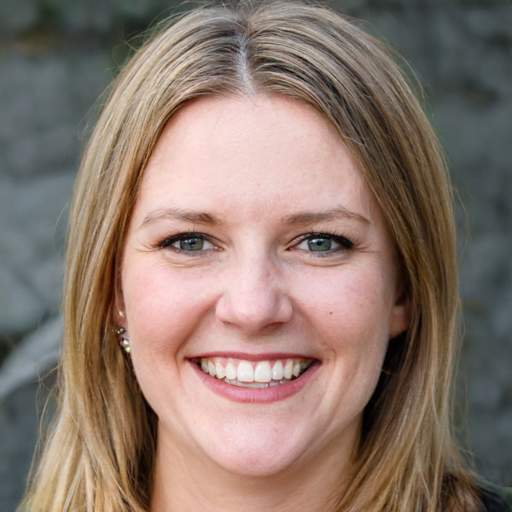

In [ ]:
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage

mean_latent = g_ema.mean_latent(4096)

latent_code_init_not_trunc = torch.randn(1,512).cuda()
with torch.no_grad():
  img_orig,latent_code_init=g_ema([latent_code_init_not_trunc],return_latents=True,truncation=0.7,truncation_latent=mean_latent)

image=ToPILImage()(make_grid(img_orig.detach().cpu(),normalize=True,scale_each=True,
                             range=(-1,1),padding=0))
h,w=image.size
image.resize((h//2,w//2))

In [ ]:
from argparse import Namespace 
args = Namespace()
args.description = 'A really sad face'
args.lr_ramp = 0.05
args.lr = 0.1
args.step = 150
args.l2_lambda = 0.005
args.save_intermediate_image_every = 1
args.results_dir = 'results'

In [ ]:
import os
import math
import torchvision
import torch
from torch import optim

def get_lr(t,initial_lr,rampdown=0.50,rampup=0.05):
  lr_ramp = min(1,(1-t)/rampdown)
  lr_ramp = 0.5 - 0.5 * math.cos(lr_ramp * math.pi)
  lr_ramp = lr_ramp *min(1, t/rampup)

  return initial_lr * lr_ramp

text_inputs = torch.cat([clip.tokenize(args.description)]).cuda()
os.makedirs(args.results_dir, exist_ok=True)

latent = latent_code_init.detach().clone()
latent.requires_grad = True

clip_loss = CLIPLoss()
optimizer = optim.Adam([latent],lr=args.lr)

for i in range(args.step):
  t = i/args.step
  lr = get_lr(t,args.lr)
  optimizer.param_groups[0]['lr'] = lr

  img_gen, _ = g_ema([latent], input_is_latent=True, randomize_noise=False)

  c_loss = clip_loss(img_gen, text_inputs)
  l2_loss = ((latent_code_init - latent)**2).sum()
  loss = c_loss + args.l2_lambda *l2_loss

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  print(f"lr: {lr}, loss: {loss.item():.4f}")
  if args.save_intermediate_image_every > 0 and i % args.save_intermediate_image_every==0:
    with torch.no_grad():
      img_gen, _=g_ema([latent],input_is_latent=True, randomize_noise=False)
    torchvision.utils.save_image(img_gen,f"results/{str(i).zfill(5)}.png",normalize=True, range=(-1,1))

with torch.no_grad():
  img_orig,_ = g_ema([latent_code_init],input_is_latent=True,randomize_noise=False)

final_result = torch.cat([img_orig,img_gen])



100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 147MiB/s]


lr: 0.0, loss: 0.8115
lr: 0.013333333333333334, loss: 0.8115
lr: 0.02666666666666667, loss: 0.8096
lr: 0.04, loss: 0.8105
lr: 0.05333333333333334, loss: 0.8145
lr: 0.06666666666666667, loss: 0.8223
lr: 0.08, loss: 0.8276
lr: 0.09333333333333334, loss: 0.8301
lr: 0.1, loss: 0.8618
lr: 0.1, loss: 0.8701
lr: 0.1, loss: 0.8721
lr: 0.1, loss: 0.8652
lr: 0.1, loss: 0.8535
lr: 0.1, loss: 0.8496
lr: 0.1, loss: 0.8662
lr: 0.1, loss: 0.8369
lr: 0.1, loss: 0.8530
lr: 0.1, loss: 0.8550
lr: 0.1, loss: 0.8384
lr: 0.1, loss: 0.8403
lr: 0.1, loss: 0.8301
lr: 0.1, loss: 0.8354
lr: 0.1, loss: 0.8418
lr: 0.1, loss: 0.8369
lr: 0.1, loss: 0.8340
lr: 0.1, loss: 0.8193
lr: 0.1, loss: 0.8262
lr: 0.1, loss: 0.8379
lr: 0.1, loss: 0.8232
lr: 0.1, loss: 0.8369
lr: 0.1, loss: 0.8052
lr: 0.1, loss: 0.8091
lr: 0.1, loss: 0.8257
lr: 0.1, loss: 0.8154
lr: 0.1, loss: 0.8159
lr: 0.1, loss: 0.8223
lr: 0.1, loss: 0.8130
lr: 0.1, loss: 0.8242
lr: 0.1, loss: 0.8179
lr: 0.1, loss: 0.8154
lr: 0.1, loss: 0.8057
lr: 0.1, loss: 

AttributeError: ignored

In [ ]:
torchvision.utils.save_image(final_result.detach().cpu(),os.path.join(args.results_dir,"final_result.jpg"),normalize=True,scale_each=True,range=(-1,1))

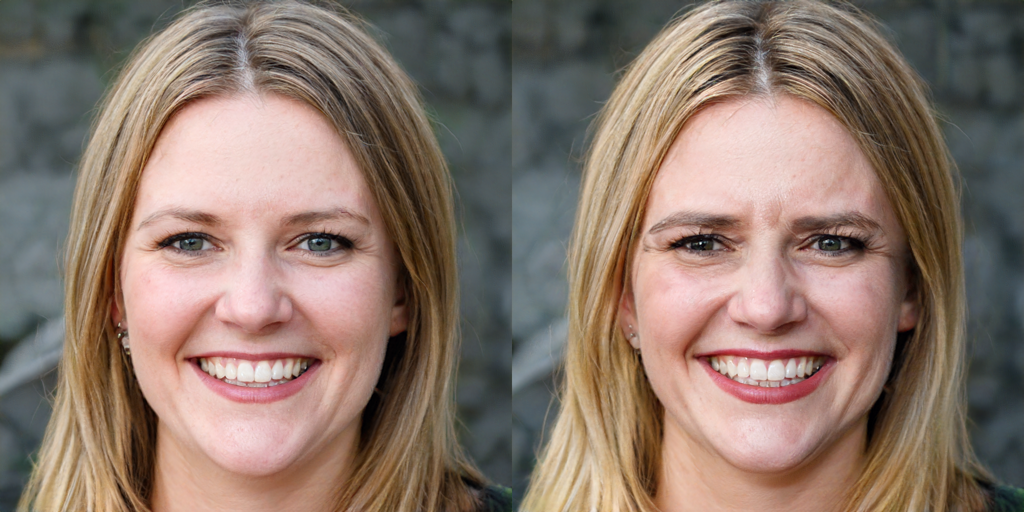

In [ ]:
result_image = ToPILImage()(make_grid(final_result.detach().cpu(), normalize=True, scale_each=True, range=(-1, 1), padding=0))
h, w = result_image.size
result_image.resize((h // 2, w // 2))

In [ ]:
!ffmpeg -r 15 -i results/%05d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p out.mp4

from google.colab import files
files.download('out.mp4')

ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>